In [36]:
# our nice list of imports is in here
#i hate this, but the notebook won't recognize our custom modules w/o it
import sys
sys.path.append("..")
import lib
from lib import utils

import os
import cv2
import urllib
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from shutil import copyfile, move

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, CSVLogger
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


import sklearn
from sklearn.preprocessing import LabelEncoder

from mtcnn.mtcnn import MTCNN

from IPython.display import clear_output

import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

# Face Mask Detection - Mask vs. No Mask (MNM)


### Brief Overview

Simply put, our goal is to create a neural network that will identify face masks or lack thereof on a human face.

### Data

The dataset used in this notebook is an amalgamation of images with face masks and images without face masks that we combined from two datasets, and augmented with the Keras `ImageDataGenerator` ([docs](https://keras.io/api/preprocessing/image/)):
  1. [Kaggle -- Mask Detection Dataset](https://www.kaggle.com/moussaid/mask-detection)
  2. [Prajna Bhandary's Dataset (`prajnasb/observations`)](https://github.com/prajnasb/observations)


### Model

+ We'll be using the Keras `Sequential` model. More description as we get closer to it.


In [37]:
# define directory paths for easier navigation
NOTEBOOK_DIR = !pwd
NOTEBOOK_DIR = NOTEBOOK_DIR[0]
ROOT_DIR = os.path.abspath(os.path.join(NOTEBOOK_DIR, os.pardir))
DATA_DIR = os.path.join(ROOT_DIR, 'data')
IMAGES_DIR = os.path.join(DATA_DIR, 'images')
IMG_DATA_DIR = os.path.join(DATA_DIR, 'img_data')
KAGGLE_DIR = os.path.join(IMAGES_DIR, 'kaggle')
HC_DATA_DIR = os.path.join(DATA_DIR, 'haar_cascades')

EXTENDED_SRC_DIR = os.path.join(DATA_DIR, 'extended-dataset')
EMASK_SRC = os.path.join(EXTENDED_SRC_DIR, 'mask')
ENOMASK_SRC = os.path.join(EXTENDED_SRC_DIR, 'nomask')

ETRAINING_DIR = os.path.join(EXTENDED_SRC_DIR, 'dest/train')
ETESTING_DIR = os.path.join(EXTENDED_SRC_DIR, 'dest/test')
EVAL_DIR = os.path.join(EXTENDED_SRC_DIR, 'dest/val')

ETRAINING_MASK = os.path.join(EXTENDED_SRC_DIR, 'dest/train/mask')
ETESTING_MASK = os.path.join(EXTENDED_SRC_DIR, 'dest/test/mask')
EVAL_MASK = os.path.join(EXTENDED_SRC_DIR, 'dest/val/mask')

ETRAINING_NOMASK = os.path.join(EXTENDED_SRC_DIR, 'dest/train/nomask')
ETESTING_NOMASK = os.path.join(EXTENDED_SRC_DIR, 'dest/test/nomask')
EVAL_NOMASK = os.path.join(EXTENDED_SRC_DIR, 'dest/val/nomask')

KAGGLE_IMAGES_DIR = "https://github.com/brtonnies/face-mask-detection/blob/data-branch/data/images"

# Mask vs. No Mask (MNM)
---

## Model Preparations

+ We keep pre-compiled versions of our different models on hand (again, to reduce process/load times)
+ Unless the training data changes, we default to using those existing models

Number of examples: 2794
Percentage of positive examples: 41.08804581245526%, number of pos examples: 1148
Percentage of negative examples: 58.91195418754474%, number of neg examples: 1646


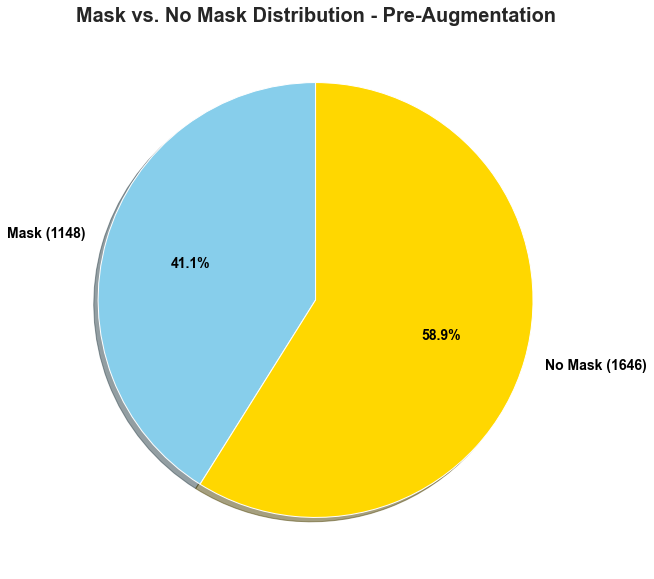

In [38]:
def data_summary(main_path):
    yes_path = main_path+'/mask'
    no_path = main_path+'/nomask'
        
    m_pos = len(os.listdir(yes_path))
    m_neg = len(os.listdir(no_path))
    m = (m_pos+m_neg)
    
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m
    
    fig = plt.figure(figsize=(10, 10))
    plt.pie(
        [m_pos, m_neg], 
        labels =['Mask ({})'.format(m_pos), 'No Mask ({})'.format(m_neg)],  
        autopct='%1.1f%%',
        shadow=True, 
        startangle=90, 
        colors=['skyblue', 'gold'],
        textprops={'size': 14, 'weight': 'bold', 'color': 'black'}
    )
    plt.title("Mask vs. No Mask Distribution - Pre-Augmentation", size=20, weight='bold')

    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}") 
    
augmented_data_path = EXTENDED_SRC_DIR
data_summary(augmented_data_path)

# Generate Augmented Images for More Data

In [39]:
def augment_dataset(n=5, batch_size=5):
    import re
    
    # detector = MTCNN()
    # how many versions of each image do we want to generate?

    datagen = ImageDataGenerator(rescale=1.0/255,
                                 rotation_range=90,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 fill_mode='nearest')

    image_formats = ['png', 'jpg', 'jpeg']
    images = [i for i in os.listdir(EMASK_SRC) + os.listdir(ENOMASK_SRC) if i.split(".")[-1] in image_formats]
    not_aug = [img for img in images if "augmented" not in img]
    aug = [img for img in images if img not in not_aug]

    mask_naug = [i for i in not_aug if i in os.listdir(EMASK_SRC)]
    a = [int(re.search('\d+', img).group(0)) for img in aug]
    a.sort()

    i = a[-1] + 1
    i0 = i
    for img in mask_naug:
        image = load_img(os.path.join(EMASK_SRC, img))
        x = img_to_array(image)
        x = x.reshape((1,) + x.shape)

        for batch in datagen.flow(
            x, batch_size=batch_size, save_to_dir=EMASK_SRC, 
            save_prefix="augmented", save_format='jpg'
        ):
            i += 1
            if i - i0 > n:
                break

    not_aug = [img for img in images if "augmented" not in img]
    nomask_naug = [i for i in not_aug if i in os.listdir(ENOMASK_SRC)]
    a = [int(re.search('\d+', img).group(0)) for img in aug]
    a.sort()

    i = a[-1] + 1
    i0 = i
    for img in nomask_naug:
        image = load_img(os.path.join(ENOMASK_SRC, img))
        x = img_to_array(image)
        x = x.reshape((1,) + x.shape)

        for batch in datagen.flow(
            x, batch_size=batch_size, save_to_dir=ENOMASK_SRC, 
            save_prefix="augmented", save_format='jpg'
        ):
            i += 1
            if i - i0 > n:
                break

# comment out below to prevent dataset augmentation
augment_dataset()

# Split the Data for Training/Testing

In [40]:
def split_data(src, train, test, split_size):
    dataset = []
    
    for unitData in os.listdir(src):
        data = os.path.join(src, unitData)
        if(os.path.getsize(data) > 0 and os.path.isfile(data)):
            dataset.append(unitData)
        else:
            print('Skipped ' + unitData)
            print('Invalid file i.e zero size')
    
    train_set_length = int(len(dataset) * split_size)
    test_set_length = int(len(dataset) - train_set_length)
    shuffled_set = random.sample(dataset, len(dataset))
    train_set = dataset[0:train_set_length]
    test_set = dataset[-test_set_length:]
       
    for unitData in train_set:
        temp_train_set = os.path.join(src, unitData)
        final_train_set = os.path.join(train, unitData)
        
        copyfile(temp_train_set, final_train_set)
    
    for unitData in test_set:
        temp_test_set = os.path.join(src, unitData)
        final_test_set = os.path.join(test, unitData)
        copyfile(temp_test_set, final_test_set)

        
split_size = 0.8
split_data(EMASK_SRC, ETRAINING_MASK, ETESTING_MASK, split_size)
split_data(ENOMASK_SRC, ETRAINING_NOMASK, ETESTING_NOMASK, split_size)


# Visualizing the Augmented Data Distribution

Text(0.5, 1.0, 'Mask vs. No Mask Distribution - Testing')

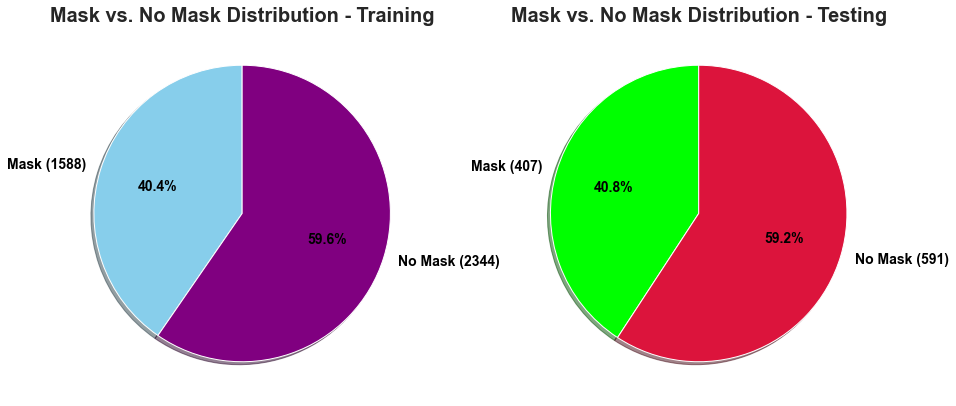

In [41]:
mask_ct = os.listdir(ETRAINING_MASK)
nomask_ct = os.listdir(ETRAINING_NOMASK)
mask_tst = os.listdir(ETESTING_MASK)
nomask_tst = os.listdir(ETESTING_NOMASK)

fig = plt.figure(figsize=(15, 15))

plt.subplot(221)
plt.pie(
    [len(mask_ct), len(nomask_ct)], 
    labels =['Mask ({})'.format(len(mask_ct)), 'No Mask ({})'.format(len(nomask_ct))], 
    autopct = '%1.1f%%',
    shadow = True, 
    startangle = 90, 
    colors = ['skyblue', 'purple'],
    textprops = { 'size': 14, 'weight': 'bold', 'color': 'black' }
)
plt.title("Mask vs. No Mask Distribution - Training", size=20, weight='bold')

plt.subplot(222)
plt.pie(
    [len(mask_tst), len(nomask_tst)], 
    labels =['Mask ({})'.format(len(mask_tst)), 'No Mask ({})'.format(len(nomask_tst))], 
    autopct="%1.1f%%",
    shadow=True, 
    startangle=90, 
    colors=['lime', 'crimson'],
    textprops={'size': 14, 'weight': 'bold', 'color': 'black'}
)
plt.title("Mask vs. No Mask Distribution - Testing", size=20, weight='bold')

---
## Keras Sequential Model

#### Building the Model
In this proposed method, the Face Mask detection model is built using the Sequential API of the keras library. This allows us to create the new layers for our model step by step. The various layers used for our CNN model are described below.

1. The first layer is Conv2D with **100 kernels** of size $3\times3$. 
  + The activation function is ‘ReLu’.  
  + The input size is set to $50\times 50 \times 3$ for all the images to be trained and tested

2. The layer is followed by MaxPooling2D -- used for the second layer with pool size of $2 \times 2$.

3. The next layer is another Conv2D layer 
  + Has its own 64 kernels of the same size: $3\times3$ 
  + Activation function is ‘ReLu’. 

4. The layer is followed by another MaxPooling2D layer with pool size $2 \times 2$.

5. Then the Flatten() layer to flatten *all* the layers into a single dimension.

6. Then we used the Dense layer 
  + 50 'units' 
  + Activation function: ‘ReLu’.

7. Dropout (0.2) layer to prevent the model from overfitting (very difficult problem here)

8. The last layer of our model will be another Dense Layer
  + 2 'units'
  + Activation function ‘Softmax’

\textbf{Expected result:} the output from the softmax layer will be a vector with two probability distribution values: is there a mask on this face or not?

---

In [42]:
kernel_size = (3, 3)
image_shape = (50, 50, 3)
alpha = 0.001
eps = 1e-5
batch_size = 5
epochs = 40

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        100, 
        kernel_size, 
        activation='relu', 
        input_shape=image_shape, 
        strides=2,
    ),
    tf.keras.layers.MaxPooling2D(2,2),
    
    
    tf.keras.layers.Conv2D(
        64, 
        kernel_size, 
        activation='relu',
    ),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='relu'),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax'),
])

opt = tf.keras.optimizers.Adam(learning_rate=alpha, epsilon=eps)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

## Generating Training/Testing/Validation Data

In [43]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    ETRAINING_DIR, 
    batch_size=batch_size, 
    target_size=(50, 50)
)

validation_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=90,
    horizontal_flip=True
)

validation_generator = validation_datagen.flow_from_directory(
    ETESTING_DIR, 
    batch_size=batch_size, 
    target_size=(50, 50)
)

Found 3926 images belonging to 2 classes.
Found 996 images belonging to 2 classes.


In [ ]:
model_path = '../models/mnm/presentation'
checkpoint_path = '../models/mnm/presentation/presentation2.checkpoint'

# NOTE: here's something cool - we can use checkpoints
#       to save/load the weights from previous model training:
# if os.path.exists(checkpoint_path):
#     model.load_weights(os.path.join(checkpoint_path, 'variables/variables'))
    
# alternatively --> we can load the whole model from the checkpoint state
if os.path.exists(checkpoint_path):
    model = load_model(checkpoint_path)


checkpoint = ModelCheckpoint(
    checkpoint_path, 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True,
    mode = 'auto'
)
logger = CSVLogger(os.path.join(model_path, 'logs/training2.csv'))

history = model.fit_generator(
    train_generator,
    epochs = epochs,
#     epochs=15,                              # option to speed up training for presentation
#     steps_per_epoch=100,                    # option to speed up training for presentation
    validation_data = validation_generator,
    callbacks = [checkpoint, logger]
)

Epoch 1/40
785/786 [============================>.] - ETA: 0s - loss: 0.3170 - acc: 0.8633
Epoch 00001: val_loss improved from inf to 0.25121, saving model to ../models/mnm/presentation/presentation2.checkpoint
INFO:tensorflow:Assets written to: ../models/mnm/presentation/presentation2.checkpoint/assets
786/786 [==============================] - 98s 125ms/step - loss: 0.3170 - acc: 0.8632 - val_loss: 0.2512 - val_acc: 0.8896
Epoch 2/40
785/786 [============================>.] - ETA: 0s - loss: 0.3189 - acc: 0.8707
Epoch 00002: val_loss did not improve from 0.25121
786/786 [==============================] - 101s 128ms/step - loss: 0.3198 - acc: 0.8704 - val_loss: 0.2752 - val_acc: 0.8835
Epoch 3/40
785/786 [============================>.] - ETA: 0s - loss: 0.3203 - acc: 0.8689
Epoch 00003: val_loss did not improve from 0.25121
786/786 [==============================] - 100s 128ms/step - loss: 0.3207 - acc: 0.8683 - val_loss: 0.2832 - val_acc: 0.8665
Epoch 4/40
785/786 [=================

---
# How Did We Do?

To answer that, we have to answer a few other questions:
1. What do the training/validation results look like?
  + Can we accurately predict the data in the dataset source images?
2. How well does our model predict a completely different dataset?
  + For this, we'll use the training set from Kaggle so we can also check our accuracy
3. How well does our model predict in a different setting?
  + We'll use a live WebCam feed or video file and have our model predict in real time (or close to it -- framerate is spotty)

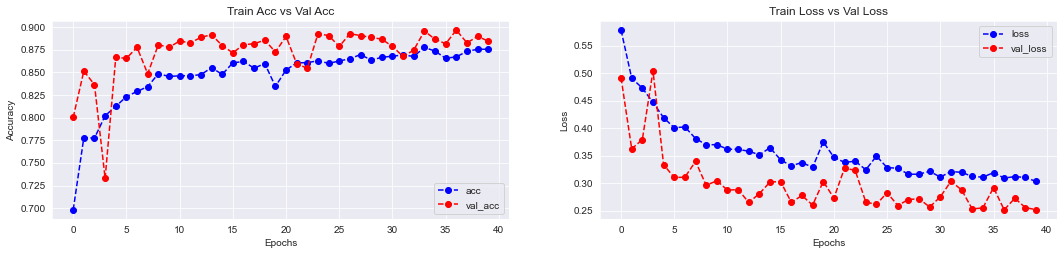

In [46]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(18,8))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['acc'],'bo--', label = "acc")
    plt.plot(history.history['val_acc'], 'ro--', label = "val_acc")
    plt.title("Train Acc vs Val Acc")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("Train Loss vs Val Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")

    plt.legend()
    plt.show()
    
plot_accuracy_loss(history)
# history.history
# model.history

---
# Predicting

Our model's performance in the training/validation stage was admirable.  Let's give it some images and see how it performs with them.

---

## Using Our Model With Video Feed

+ We have two available facial detection algorithms: 
  1. Haar Cascade - faster detection, but only tuned for full, frontal views of faces.
  2. MTCNN - slower detection, but returns extra features and can detect faces from a variety of angles -- not only the front.


In [48]:
# use haar cascade to detect faces (frontal)
# HC_FRONTAL_FACE = os.path.join(HC_DATA_DIR, 
#                                'haarcascade_frontalface_default.xml')
# classifier = cv2.CascadeClassifier(HC_FRONTAL_FACE)


# use MTCNN to detect faces
classifier = MTCNN()


labels_dict={ 0:'No Mask', 1:'Mask' }
color_dict={ 0: (0,0,255), 1: (0,255,0) }

size = 4

# open webcam feed
# cap = cv2.VideoCapture(0)

# alternatively, open feed from a file
cap = cv2.VideoCapture('../memask4.mov')

# EVEN from a mobile device (UNTESTED)
# cap = cv.VideoCapture(1)

while cap.isOpened():
    ret, frame = cap.read()
    if frame is not None:
        # frame = cv2.flip(frame, 1, 1) # flip so view looks more natural live (?)
        

        # detection is a little faster on smaller images -- so let's make it small
        small = cv2.resize(frame, (frame.shape[1] // size, frame.shape[0] // size))

        # detect faces with haar cascades
        # faces = classifier.detectMultiScale(small)
        
        # detect faces with MTCNN
        faces = classifier.detect_faces(small)

        for f in faces:
            # reverse the scale-down of the frame for bounding box (haar)
            # (x, y, w, h) = [v * size for vstack in f] 
            # keypoints = None
            
            # reverse the scale-down of the frame for bounding box (MTCNN)
            (x, y, w, h) = [v * size for v in f['box']]
            keypoints = f['keypoints']
            p_face = f['confidence']
            p_noface = 1 - p_face
#             print("P(Face): {}\nP(No Face): {}".format(p_face, p_noface))
                
        
            face = frame[y:y+h, x:x+w]
            resized = cv2.resize(face, (50,50))
            normalized = resized/255.0
            reshaped = np.reshape(normalized,(-1,50,50,3))
            reshaped = np.vstack([reshaped])
            result = model.predict(reshaped)
            
            result[0][0] = (p_face * result[0][0]) / p_face
            result[0][1] = (p_noface * result[0][1]) / p_face
        
            print(result)
            
            label = np.argmax(result, axis=1)[0]
            cv2.rectangle(frame, (x,y), (x+w,y+h), color_dict[label], 2)
            cv2.rectangle(frame, (x,y-40), (x+w,y), color_dict[label], -1)
            cv2.putText(
                frame, 
                labels_dict[label], 
                (x, y-10), 
                cv2.FONT_HERSHEY_SIMPLEX,
                0.8,
                (255,255,255),
                2
            )
            
            # extra fun when using MTCNN :)
            if keypoints is not None:
                cv2.circle(
                    frame, 
                    (tuple([k * size for k in keypoints['left_eye']])), 
                    2, (255,0,255), 2
                )
                cv2.circle(
                    frame, 
                    (tuple([k * size for k in keypoints['right_eye']])), 
                    2, (255,0,255), 2
                )
                cv2.circle(
                    frame, 
                    (tuple([k * size for k in keypoints['nose']])), 
                    2, (255,0,255), 2
                )
                cv2.circle(
                    frame, 
                    (tuple([k * size for k in keypoints['mouth_left']])), 
                    2, (255,0,255), 2
                )
                cv2.circle(
                    frame, 
                    (tuple([k * size for k in keypoints['mouth_right']])), 
                    2, (255,0,255), 2)
            # end of extra fun with MTCNN

        cv2.imshow('LIVE DETECTION ACTIVE', frame)
        key = cv2.waitKey(10)

        if key == 27: # if Esc key pressed -- end feed
            break
        
    else:
        break

[[0.07346735 0.12063099]]
[[0.07517937 0.02024039]]
[[0.07999498 0.06650587]]
[[0.0799708  0.06919339]]
[[0.08793896 0.10305931]]
[[0.08778276 0.13809676]]
[[0.08335118 0.0788957 ]]
[[0.08983313 0.13279364]]
[[0.08451212 0.0795654 ]]
[[0.08840631 0.15184331]]
[[0.06561646 0.15076065]]
[[0.08640527 0.08091378]]
[[0.09378947 0.1652501 ]]
[[0.07868095 0.09939943]]
[[0.07873099 0.10438848]]
[[0.08890001 0.15982658]]
[[0.09012008 0.1483901 ]]
[[0.08586231 0.09942179]]
[[0.08963104 0.11623225]]
[[0.07180922 0.11517616]]
[[0.08964919 0.15218234]]
[[0.08959739 0.15613125]]
[[0.07476846 0.29741153]]
[[0.08801515 0.23071277]]
[[0.09003028 0.28354004]]
[[0.07080151 0.18682197]]
[[0.07368074 0.13396631]]
[[0.09167677 0.1354299 ]]
[[0.07453111 0.15200241]]
[[0.07018307 0.14497513]]
[[0.06834701 0.16924068]]
[[0.08696697 0.10313053]]
[[0.07526971 0.21911284]]
[[0.07384308 0.10213817]]
[[0.06886579 0.10595997]]
[[0.07661448 0.08038373]]
[[0.09431843 0.07742842]]
[[0.100498   0.15628675]]
[[0.06809631

In [ ]:
cap.release()
cv2.destroyAllWindows()